In [67]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [68]:
import download
import mlpipeline
import helper

In [75]:
params = {
    'to_exclude': ['year', 'label'],
    'top_x_percent': 0.1,
    'date_col': 'filing_year',
    'prediction_window': 12,
    'start_time': '2010-01-01',
    'end_time': '2016-01-01',
    'len_train': 36,
    'discrete_bins': 3,
    'cats': ['low', 'medium', 'high'],
    'outcome': 'label',
    'model_params': {
    'LR': {
        'C': 10,
        'class_weight': None,
        'penalty': 'l2',
        'fit_intercept': True,
        'intercept_scaling': 1,
        'max_iter': 100,
        'multi_class': 'warn',
        'n_jobs': None,
        'random_state': 1234,
        'solver': 'warn',
        'tol': 0.0001,
        'verbose': 0,
        'warm_start': False}},
    'RF': {
        
    }
        }

In [13]:
eviction = download.load_evict('../inputs/eviction_data_tract.csv')
crime = download.load_crime('../inputs/crime_by_tract.csv')
buildings = download.load_building('../inputs/building_violation_by_tract.csv')
acs = download.load_acs('../inputs/acs_year_tract.csv')
education = download.load_education('../inputs/educ_year_tract.csv')
tracts = download.load_tract('../inputs/ch_opdat/tracts.csv')
eviction_df = download.join_bases(eviction, acs, education, crime, buildings, tracts)

In [14]:
eviction_df = mlpipeline.create_label(eviction_df, 'year', 'eviction_filings_rate', 1 - params['top_x_percent'],
                                      params['prediction_window'])
eviction_df = eviction_df.drop(['eviction_filings_rate_next_year', 'next_year'], axis = 1)

In [108]:
train_set = eviction_df.loc[eviction_df['year'] != 2017].copy()
test_set = eviction_df.loc[eviction_df['year'] == 2017].copy()

In [109]:
cols_to_discretize = mlpipeline.get_continuous_variables(eviction_df)
cols_to_binary = []
for col in cols_to_discretize:
     cols_to_binary.append(col + "_group")

In [110]:
process_train = mlpipeline.process_df(train_set, cols_to_discretize, params['discrete_bins'],
                                      params['cats'], cols_to_binary)

perc_increase_total_crime_class_Violent Crime                             799
perc_increase_total_crime_class_Property Crime                            797
perc_increase_total_crime_class_Less serious offences_mean_by_commarea    796
perc_increase_bv_mean_by_commarea                                         796
perc_increase_bv                                                          796
perc_increase_total_crime_class_Less serious offences                     796
perc_increase_total_crime                                                 796
perc_increase_total_crime_class_Violent Crime_mean_by_commarea            796
perc_increase_total_crime_class_Property Crime_mean_by_commarea           796
perc_increase_total_crime_mean_by_commarea                                796
population_race_asian                                                      21
population_race_latinx                                                     21
population_race_other                                           

In [111]:
selected_features = list(process_train.loc[:,process_train.apply(lambda x: x.isin([0, 1]).all())].columns)
selected_features.remove('label')
predictors = selected_features

In [112]:
process_test = mlpipeline.process_df(test_set, cols_to_discretize, params['discrete_bins'],
                                      params['cats'], cols_to_binary)

race                                                              4
housing_units_other                                               4
population_race_asian                                             4
population_race_latinx                                            4
population_race_black                                             4
population_race_white                                             4
population_poverty_above                                          4
population_poverty_below                                          4
population_race_other                                             4
housing_units_rental                                              4
perc_increase_total_crime_class_Violent Crime                     1
total_primary_type_WEAPONS VIOLATION                              0
total_primary_type_OTHER OFFENSE                                  0
total_primary_type_PUBLIC INDECENCY                               0
total_primary_type_PUBLIC PEACE VIOLATION       

In [113]:
x_train = process_train[selected_features]
y_train = process_train['label']
x_test = process_test[selected_features]

In [137]:
lr_pred = mlpipeline.run_model(x_train, y_train, x_test, params['model_to_run'],
                               params['model_params'][params['model_to_run']])

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [158]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [172]:
clf_lr = LogisticRegression(C= 10,
                        class_weight= None,
                        penalty= 'l2',
                        fit_intercept= True,
                        intercept_scaling= 1,
                        max_iter= 100,
                        multi_class= 'warn',
                        n_jobs= None,
                        random_state= 1234,
                        solver= 'warn',
                        tol= 0.0001,
                        verbose= 0,
                        warm_start= False)
clf_lr.fit(x_train, y_train)
y_pred_probs = clf.predict_proba(x_test)
test_set['predicted_lr_score'] = y_pred_probs[:,1]
test_set.sort_values('predicted_lr_score', inplace=True, ascending=False)
test_set['prediction_lr'] = helper.generate_binary_at_k(test_set['predicted_lr_score'], 10)

clf_rf = RandomForestClassifier(bootstrap=True,
                             class_weight=None,
                             criterion='gini',
                             max_depth=50,
                             max_features='log2',
                             max_leaf_nodes=None,
                             min_impurity_decrease=0.0,
                             min_impurity_split=None,
                             min_samples_leaf=1,
                             min_samples_split=10,
                             min_weight_fraction_leaf=0.0,
                             n_estimators=10000,
                             n_jobs=-1,
                             oob_score=False,
                             random_state=None,
                             verbose=0,
                             warm_start=False)

clf_rf.fit(x_train, y_train)
y_pred_probs = clf.predict_proba(x_test)
test_set['predicted_rf_score'] = y_pred_probs[:,1]
test_set.sort_values('predicted_rf_score', inplace=True, ascending=False)
test_set['prediction_rf'] = helper.generate_binary_at_k(test_set['predicted_rf_score'], 10)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [173]:
test_set[['prediction_rf', 'prediction_lr']].describe()

,prediction_rf,prediction_lr
count,799.000000,799.000000
mean,0.098874,0.098874
std,0.298679,0.298679
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,0.000000
max,1.000000,1.000000


In [174]:
test_set[['tract', 'year', 'prediction_lr', 'prediction_rf']].to_csv('../results/rf_lr_results.csv')

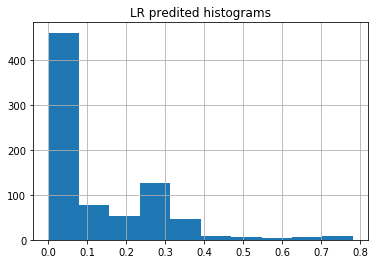

In [204]:
import matplotlib.pyplot as plt
test_set['predicted_lr_score'].hist()
plt.title('LR predited histograms')
plt.savefig('../figures/y_pred_hist_lr.png')

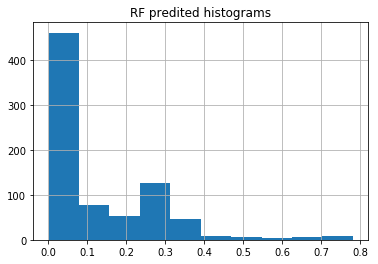

In [202]:
import matplotlib.pyplot as plt
test_set['predicted_rf_score'].hist()
plt.title('RF predited histograms')
plt.savefig('../figures/y_pred_hist_rf.png')

FEATURE IMPORTANCES

1. Feature population_race_white_mean_by_commarea_group_low (1.000000)
2. Feature total_violation_status_COMPLIED_perc_mean_by_commarea_group_medium (0.769346)
3. Feature housing_units_total_mean_by_commarea_group_low (0.760312)
4. Feature population_race_white_mean_by_commarea_group_high (0.726441)
5. Feature total_violation_status_OPEN_perc_mean_by_commarea_group_medium (0.692932)
6. Feature population_total_mean_by_commarea_group_medium (0.625469)
7. Feature total_primary_type_BATTERY_mean_by_commarea_group_medium (0.623902)
8. Feature total_primary_type_BATTERY_mean_by_commarea_group_low (0.560313)
9. Feature perc_total_crime_class_Less serious offences_mean_by_commarea_group_low (0.525431)
10. Feature total_violation_status_COMPLIED_perc_mean_by_commarea_group_high (0.508405)


<Figure size 432x288 with 0 Axes>

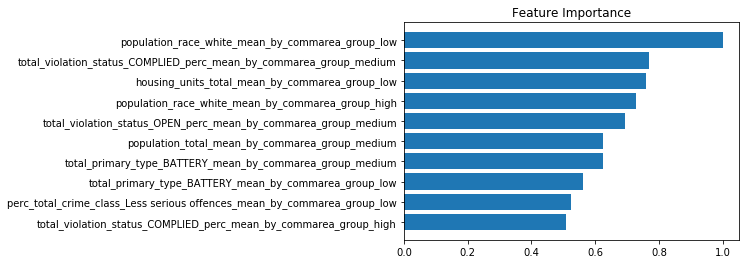

In [213]:
mlpipeline.get_feature_importance('LR', x_train, clf_lr, n_importances=10)

FEATURE IMPORTANCES

1. Feature label_prev_year (0.037739)
2. Feature population_race_black_group_high (0.012656)
3. Feature eviction_filings_rate_group_low (0.011622)
4. Feature eviction_filings_rate_mean_by_commarea_group_low (0.010873)
5. Feature eviction_filings_rate_mean_by_commarea_group_medium (0.010217)
6. Feature population_race_black_mean_by_commarea_group_high (0.009792)
7. Feature population_race_black_group_low (0.009608)
8. Feature eviction_filings_rate_group_medium (0.009155)
9. Feature population_race_black_mean_by_commarea_group_low (0.007535)
10. Feature total_primary_type_BATTERY_mean_by_commarea_group_low (0.007222)


<Figure size 432x288 with 0 Axes>

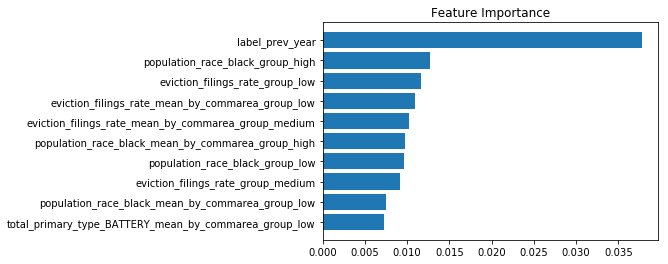

In [177]:
mlpipeline.get_feature_importance('RF', x_train, clf_rf, n_importances=10)

In [209]:
predicted_tracts = test_set.loc[test_set['prediction_lr'] == 1, 'tract'].copy()